In [1]:
import os
import re
import click
import numpy as np
from PIL import Image
import torch
from torchvision import utils, transforms
from torchvision.utils import save_image

import dnnlib
from legacy import _LegacyUnpickler, convert_tf_generator

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')


Device: cuda


### Load Model + Latent Directions

In [2]:
with dnnlib.util.open_url("stylitgan_bedroom.pkl") as f:
    Gs = _LegacyUnpickler(f).load() 
    G = convert_tf_generator(Gs)
    G = G.eval().requires_grad_(False).to(device)

directions = np.load("stylitgan_directions_7.npy")
directions = torch.tensor(directions).to(device)
zs = np.load('zs_bedroom.npy')
zs = torch.tensor(zs).to(device)

In [3]:
def make_resized_grid_image(image_tensors, resize=None, nrow=8):
    grid_image = transforms.ToPILImage()(utils.make_grid(image_tensors, nrow=nrow))
    if resize is not None:
        grid_image = transforms.Resize(resize)(grid_image)
    return grid_image

### Create Single Relight

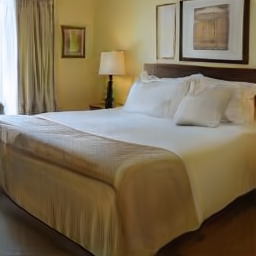

In [4]:
# Get Original Image
z = torch.randn(1, 512, device=device)
# z = zs[torch.randint(zs.size(0),(1,))]
w = G.mapping(z, c=0)
img = G.synthesis(w, noise_mode='none')
img = (img.clamp(-1, 1) + 1) / 2.0
transforms.ToPILImage()(img.squeeze(0))

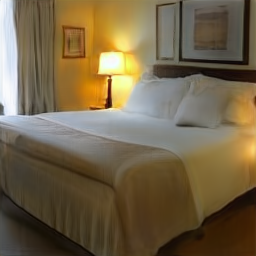

In [5]:
# Add Latent Direction to Produce Relit Image
direction = directions[0] # directions 0-6
img_relit = G.synthesis(w + direction, noise_mode='none')
img_relit = (img_relit.clamp(-1, 1) + 1) / 2.0
transforms.ToPILImage()(img_relit.squeeze(0))

### See All Relights of a Scene

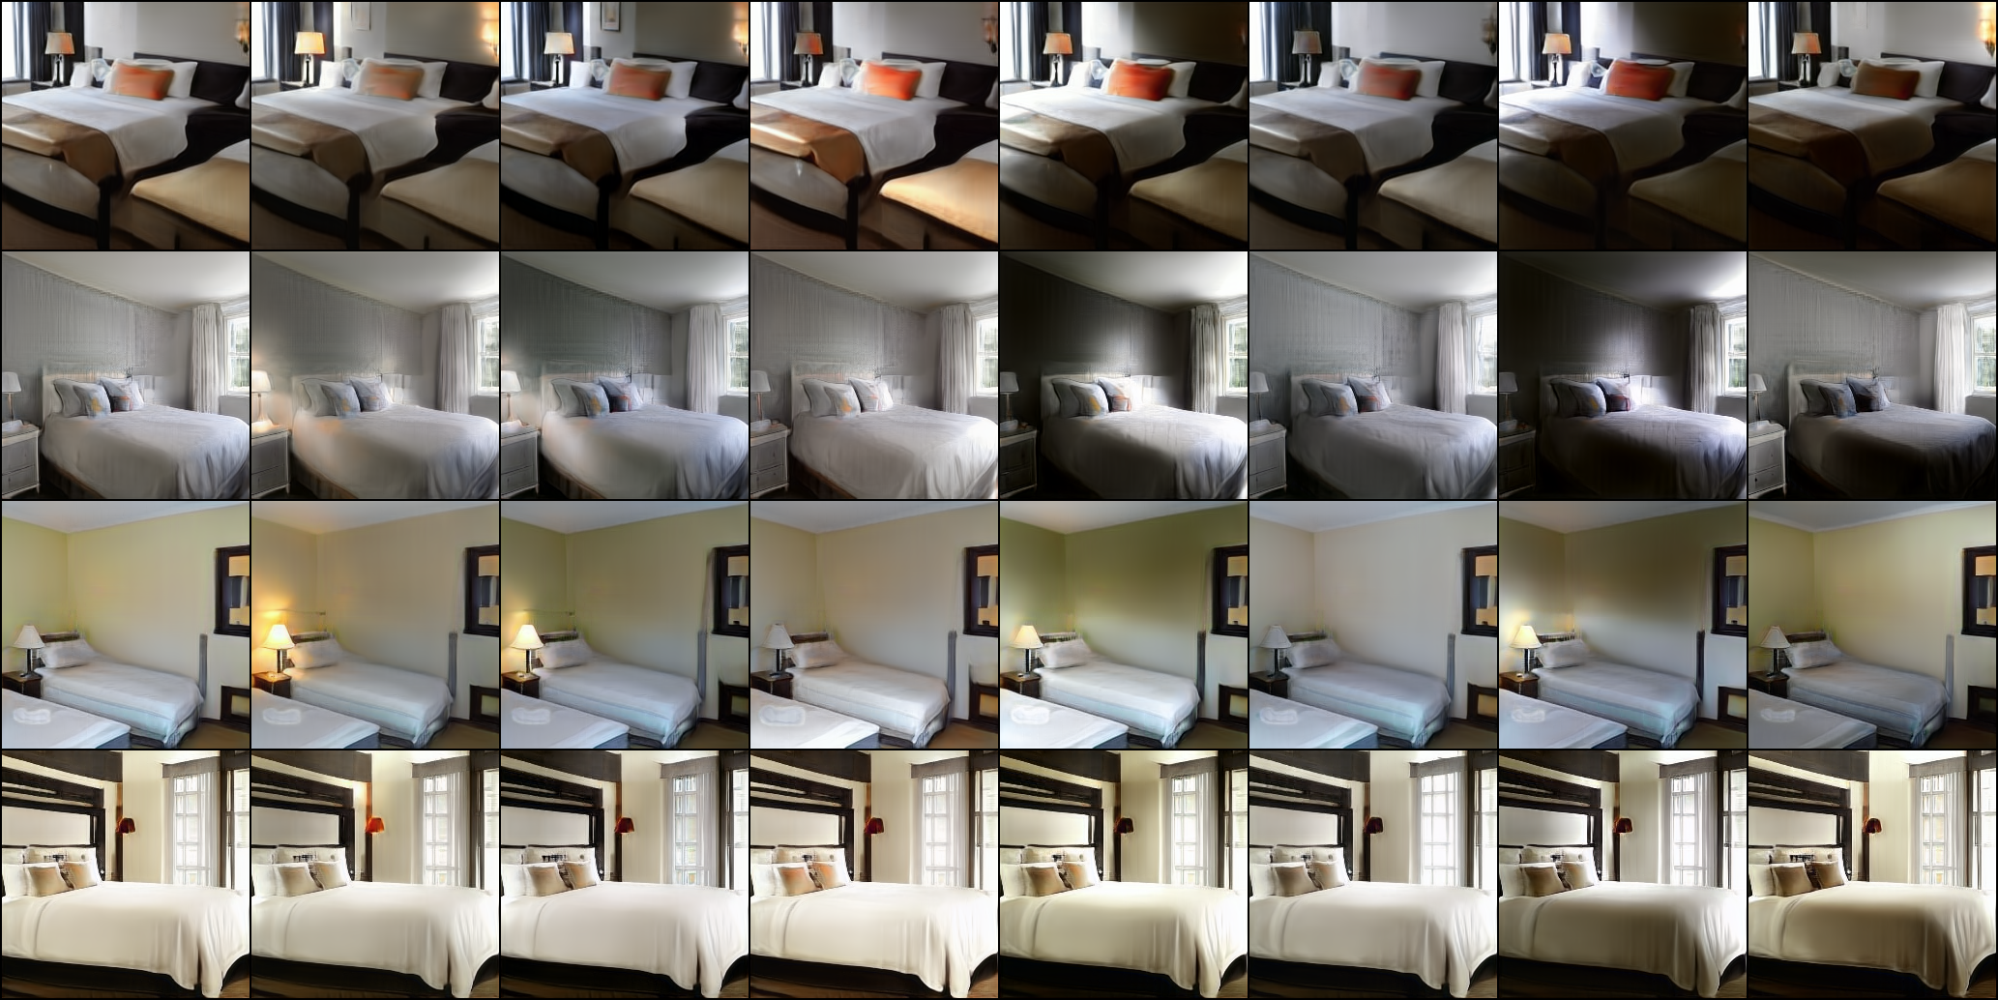

In [7]:
bs = 4
z = zs[torch.randperm(zs.size(0))[:bs]]
# z = torch.randn(bs, 512, device=device)

w = G.mapping(z, c=0)
img = G.synthesis(w, noise_mode='none')
img = (img.clamp(-1, 1) + 1) / 2.0
imgs = [img]

for i in range(len(directions)):
    img_relit = G.synthesis(w + directions[i], noise_mode='none')
    img_relit = (img_relit.clamp(-1, 1) + 1) / 2.0
    imgs.append(img_relit)

imgs = torch.cat((imgs), 0).reshape(8,bs,3,256,256).permute(1,0,2,3,4).reshape(bs*8,3,256,256)
im = make_resized_grid_image(imgs, resize=1000, nrow=1+len(directions))
im